<a href="https://colab.research.google.com/github/shreyasudaya/hls_localizationalgorithms/blob/main/HARRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import glob

In [28]:
# Kernel operation using input operator of size 3*3
def GetSobel(image, Sobel, width, height):
    # Initialize the matrix
    I_d = np.zeros((width, height), np.float32)

    # For every pixel in the image
    for rows in range(width):
        for cols in range(height):
            # Run the Sobel kernel for each pixel
            if rows >= 1 or rows <= width-2 and cols >= 1 or cols <= height-2:
                for ind in range(3):
                    for ite in range(3):
                        I_d[rows][cols] += Sobel[ind][ite] * image[rows - ind - 1][cols - ite - 1]
            else:
                I_d[rows][cols] = image[rows][cols]

    return I_d

In [29]:
# Method implements the Harris Corner Detection algorithm
def HarrisCornerDetection(image):

    # The two Sobel operators - for x and y direction
    SobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    SobelY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    w, h = image.shape

    # X and Y derivative of image using Sobel operator
    ImgX = GetSobel(image, SobelX, w, h)
    ImgY = GetSobel(image, SobelY, w, h)

    # # Eliminate the negative values
    # There are multiple ways this can be done
    # 1. Off setting with a positive value (commented out below)
    # 2. Setting negative values to Zero (commented out)
    # 3. Multiply by -1 (implemented below, found most reliable method)
    # ImgX += 128.0
    # ImgY += 128.0
    for ind1 in range(w):
        for ind2 in range(h):
            if ImgY[ind1][ind2] < 0:
                ImgY[ind1][ind2] *= -1
                # ImgY[ind1][ind2] = 0
            if ImgX[ind1][ind2] < 0:
                ImgX[ind1][ind2] *= -1
                # ImgX[ind1][ind2] = 0

    # # Display the output results after Sobel operations
    # cv2.imshow("SobelX", ImgX)
    # cv2.imshow("SobelY", ImgY)

    ImgX_2 = np.square(ImgX)
    ImgY_2 = np.square(ImgY)

    ImgXY = np.multiply(ImgX, ImgY)
    ImgYX = np.multiply(ImgY, ImgX)

    #Use Gaussian Blur
    Sigma = 1.4
    kernelsize = (3, 3)

    ImgX_2 = cv2.GaussianBlur(ImgX_2, kernelsize, Sigma)
    ImgY_2 = cv2.GaussianBlur(ImgY_2, kernelsize, Sigma)
    ImgXY = cv2.GaussianBlur(ImgXY, kernelsize, Sigma)
    ImgYX = cv2.GaussianBlur(ImgYX, kernelsize, Sigma)
    # print(ImgXY.shape, ImgYX.shape)

    alpha = 0.06
    R = np.zeros((w, h), np.float32)
    # For every pixel find the corner strength
    for row in range(w):
        for col in range(h):
            M_bar = np.array([[ImgX_2[row][col], ImgXY[row][col]], [ImgYX[row][col], ImgY_2[row][col]]])
            R[row][col] = np.linalg.det(M_bar) - (alpha * np.square(np.trace(M_bar)))
    return R

In [30]:
#### Main Program ####
firstimagename = '/content/chessboard.png'

# Get the first image
firstimage = cv2.imread(firstimagename, cv2.IMREAD_GRAYSCALE)
w, h = firstimage.shape

# Covert image to color to draw colored circles on it
bgr = cv2.cvtColor(firstimage, cv2.COLOR_GRAY2RGB)

# Corner detection
R = HarrisCornerDetection(firstimage)

# Empirical Parameter
# This parameter will need tuning based on the use-case
CornerStrengthThreshold = 600000

# Plot detected corners on image
radius = 1
color = (0, 255, 0)  # Green
thickness = 1

PointList = []

In [31]:
# Look for Corner strengths above the threshold
for row in range(w):
    for col in range(h):
        if R[row][col] > CornerStrengthThreshold:
            # print(R[row][col])
            max = R[row][col]

            # Local non-maxima suppression
            skip = False
            for nrow in range(5):
                for ncol in range(5):
                    if row + nrow - 2 < w and col + ncol - 2 < h:
                        if R[row + nrow - 2][col + ncol - 2] > max:
                            skip = True
                            break

            if not skip:
                # Point is expressed in x, y which is col, row
                cv2.circle(bgr, (col, row), radius, color, thickness)
                PointList.append((row, col))


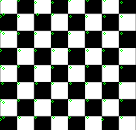

In [32]:
# Display image indicating corners and save it
cv2_imshow(bgr)
outname = "Output_" + str(CornerStrengthThreshold) + ".png"
cv2.imwrite(outname, bgr)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
'''void cv::GaussianBlur( InputArray _src, OutputArray _dst, Size ksize,
                   double sigma1, double sigma2,
                   int borderType )
{
    CV_INSTRUMENT_REGION();

    int type = _src.type();
    Size size = _src.size();
    _dst.create( size, type );

    if( (borderType & ~BORDER_ISOLATED) != BORDER_CONSTANT &&
        ((borderType & BORDER_ISOLATED) != 0 || !_src.getMat().isSubmatrix()) )
    {
        if( size.height == 1 )
            ksize.height = 1;
        if( size.width == 1 )
            ksize.width = 1;
    }

    if( ksize.width == 1 && ksize.height == 1 )
    {
        _src.copyTo(_dst);
        return;
    }

    bool useOpenCL = (ocl::isOpenCLActivated() && _dst.isUMat() && _src.dims() <= 2 &&
               ((ksize.width == 3 && ksize.height == 3) ||
               (ksize.width == 5 && ksize.height == 5)) &&
               _src.rows() > ksize.height && _src.cols() > ksize.width);
    CV_UNUSED(useOpenCL);

    int sdepth = CV_MAT_DEPTH(type), cn = CV_MAT_CN(type);

    Mat kx, ky;
    createGaussianKernels(kx, ky, type, ksize, sigma1, sigma2);

    CV_OCL_RUN(useOpenCL, ocl_GaussianBlur_8UC1(_src, _dst, ksize, CV_MAT_DEPTH(type), kx, ky, borderType));

    CV_OCL_RUN(_dst.isUMat() && _src.dims() <= 2 && (size_t)_src.rows() > kx.total() && (size_t)_src.cols() > kx.total(),
               ocl_sepFilter2D(_src, _dst, sdepth, kx, ky, Point(-1, -1), 0, borderType))

    Mat src = _src.getMat();
    Mat dst = _dst.getMat();

    Point ofs;
    Size wsz(src.cols, src.rows);
    if(!(borderType & BORDER_ISOLATED))
        src.locateROI( wsz, ofs );

    CALL_HAL(gaussianBlur, cv_hal_gaussianBlur, src.ptr(), src.step, dst.ptr(), dst.step, src.cols, src.rows, sdepth, cn,
             ofs.x, ofs.y, wsz.width - src.cols - ofs.x, wsz.height - src.rows - ofs.y, ksize.width, ksize.height,
             sigma1, sigma2, borderType&~BORDER_ISOLATED);

    CV_OVX_RUN(true,
               openvx_gaussianBlur(src, dst, ksize, sigma1, sigma2, borderType))

    CV_IPP_RUN_FAST(ipp_GaussianBlur(src, dst, ksize, sigma1, sigma2, borderType));

    if(sdepth == CV_8U && ((borderType & BORDER_ISOLATED) || !_src.getMat().isSubmatrix()))
    {
        std::vector<ufixedpoint16> fkx, fky;
        createGaussianKernels(fkx, fky, type, ksize, sigma1, sigma2);
        if (src.data == dst.data)
            src = src.clone();
        fixedSmoothInvoker<uint8_t, ufixedpoint16> invoker(src.ptr<uint8_t>(), src.step1(), dst.ptr<uint8_t>(), dst.step1(), dst.cols, dst.rows, dst.channels(), &fkx[0], (int)fkx.size(), &fky[0], (int)fky.size(), borderType & ~BORDER_ISOLATED);
        parallel_for_(Range(0, dst.rows), invoker, std::max(1, std::min(getNumThreads(), getNumberOfCPUs())));
        return;
    }

    sepFilter2D(src, dst, sdepth, kx, ky, Point(-1, -1), 0, borderType);
}
'''



'void cv::GaussianBlur( InputArray _src, OutputArray _dst, Size ksize,\n                   double sigma1, double sigma2,\n                   int borderType )\n{\n    CV_INSTRUMENT_REGION();\n\n    int type = _src.type();\n    Size size = _src.size();\n    _dst.create( size, type );\n\n    if( (borderType & ~BORDER_ISOLATED) != BORDER_CONSTANT &&\n        ((borderType & BORDER_ISOLATED) != 0 || !_src.getMat().isSubmatrix()) )\n    {\n        if( size.height == 1 )\n            ksize.height = 1;\n        if( size.width == 1 )\n            ksize.width = 1;\n    }\n\n    if( ksize.width == 1 && ksize.height == 1 )\n    {\n        _src.copyTo(_dst);\n        return;\n    }\n\n    bool useOpenCL = (ocl::isOpenCLActivated() && _dst.isUMat() && _src.dims() <= 2 &&\n               ((ksize.width == 3 && ksize.height == 3) ||\n               (ksize.width == 5 && ksize.height == 5)) &&\n               _src.rows() > ksize.height && _src.cols() > ksize.width);\n    CV_UNUSED(useOpenCL);\n\n    int s